# Stochastic Kinematically Informed Earthquake Sequences (SKIES)
1. Calculate kinematically informed random epicenter
     $$P(c(t)) = \frac{1}{1+e^{-c(t)}} + \mathrm{history}$$
     where $c(t)$ is the coupling rate at time ($t$).  This is an instantaneous formulation.  We could also do this with a more history dependent formulation.  This could include dropping probabilities after an event ruptures a triangular element much like a "state" effect.  This could sort of halo certain regions
2. Calculate random magnitude from Gutenberg-Richter distribution with a minimum magnitude based on minimum triangle area 
3. Calculate approximate rupture area, $a$ with empirical scaling law (Allen and Hayes, 2017)
4. Find subset of $n$ triangles with areas $a_n$ that sum to $a$ some factor
5. Calculate eigenfunctions for these triangles
6. Generate random Gaussian slip pattern from randomly weighted eigenvectors
7. Sigmoid scaling of slip with distance from the hypocenter so that it tapers to zero at rupture edge
8. Rescale random Gaussian slip pattern to get the magnitude correct

# This model is consistent with:
1. Gutenberg-Richter magnitude-frequency distribution
2. Utsu-Omori aftershock decay rate
3. Empirical moment magnitude to rupture area scaling laws (bi-linear Allen and Hayes, 2017)
4. Crack theory for rupture shape (circular small earthquakes)
5. Geometric fault limits on rupture width and shape
6. Estimated roughness of coseismic slip distributions
7. Earthquake slip is probabilistically focused on regions with accumulated slip deficits
8. Co-seismic and inter-seismic moment balance (can be adjusted for imbalance)
9. Geodetically constrained decadal-scale interseismic fault coupling

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import datetime
import json
import meshio
import os
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
from ismember import ismember
import matplotlib
import skies


In [3]:
FONTSIZE = 12

In [4]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)

output_path='./runs/2022_09_29_12_17_38'
Read: western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: cascadia.msh
Magnitude overview:
Maximum moment magnitude of entire mesh = 10.61
Maximum moment magnitude of single mesh element = 6.90
Minimum moment magnitude of single mesh element = 5.52
Maximum allowed moment magnitude = 9.00
Minimum allowed moment magnitude = 9.00
Maximum moment magnitude of entire mesh (10.61) exceeds MAXIMUM_EVENT_MOMENT_MAGNITUDE


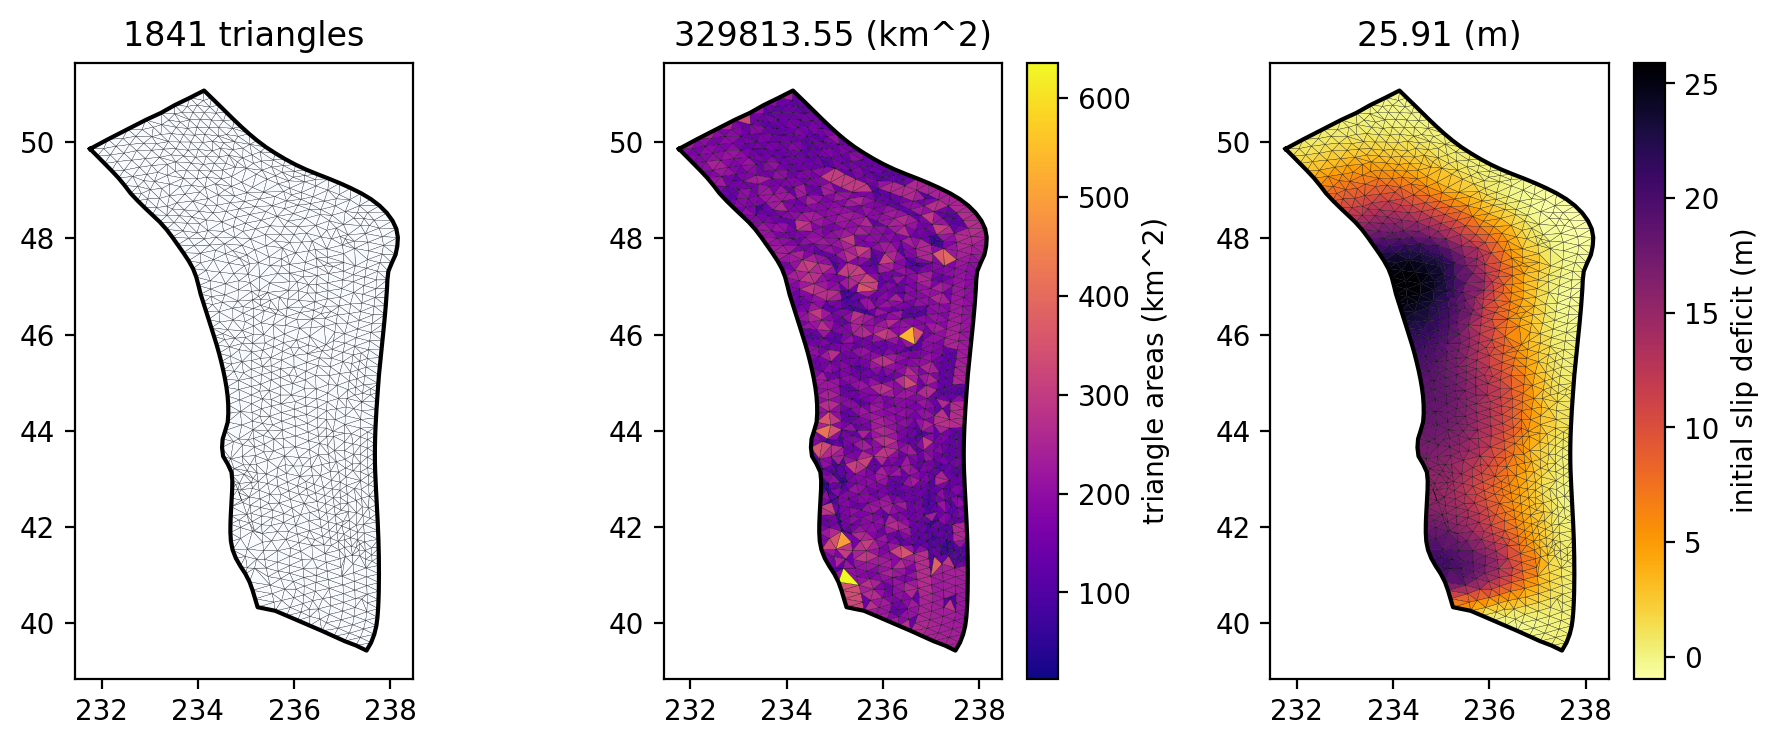

In [5]:
# Set initial conditions with accumulated slip
sources = addict.Dict()
sources.lon = np.array([235.779])
sources.lat = np.array([45.553])
sources.magnitude = np.array([10.0])
sources.slip_type = ["dip_slip"]
initial_slip_deficit = skies.get_synthetic_accumulated_slip(meshes[0], sources)
initial_dip_slip_deficit = initial_slip_deficit[1::2]

# Load initial slip defict and multiply by time cascadia_low_resolution_tde_dip_slip_rates.npy
initial_dip_slip_deficit = np.load("cascadia_low_resolution_tde_dip_slip_rates.npy")

total_coseismic_slip = np.zeros_like(initial_dip_slip_deficit)
skies.plot_initial_data(meshes, initial_dip_slip_deficit)


i=0
np.sum(pre_event_slip_deficit > 0)=1705


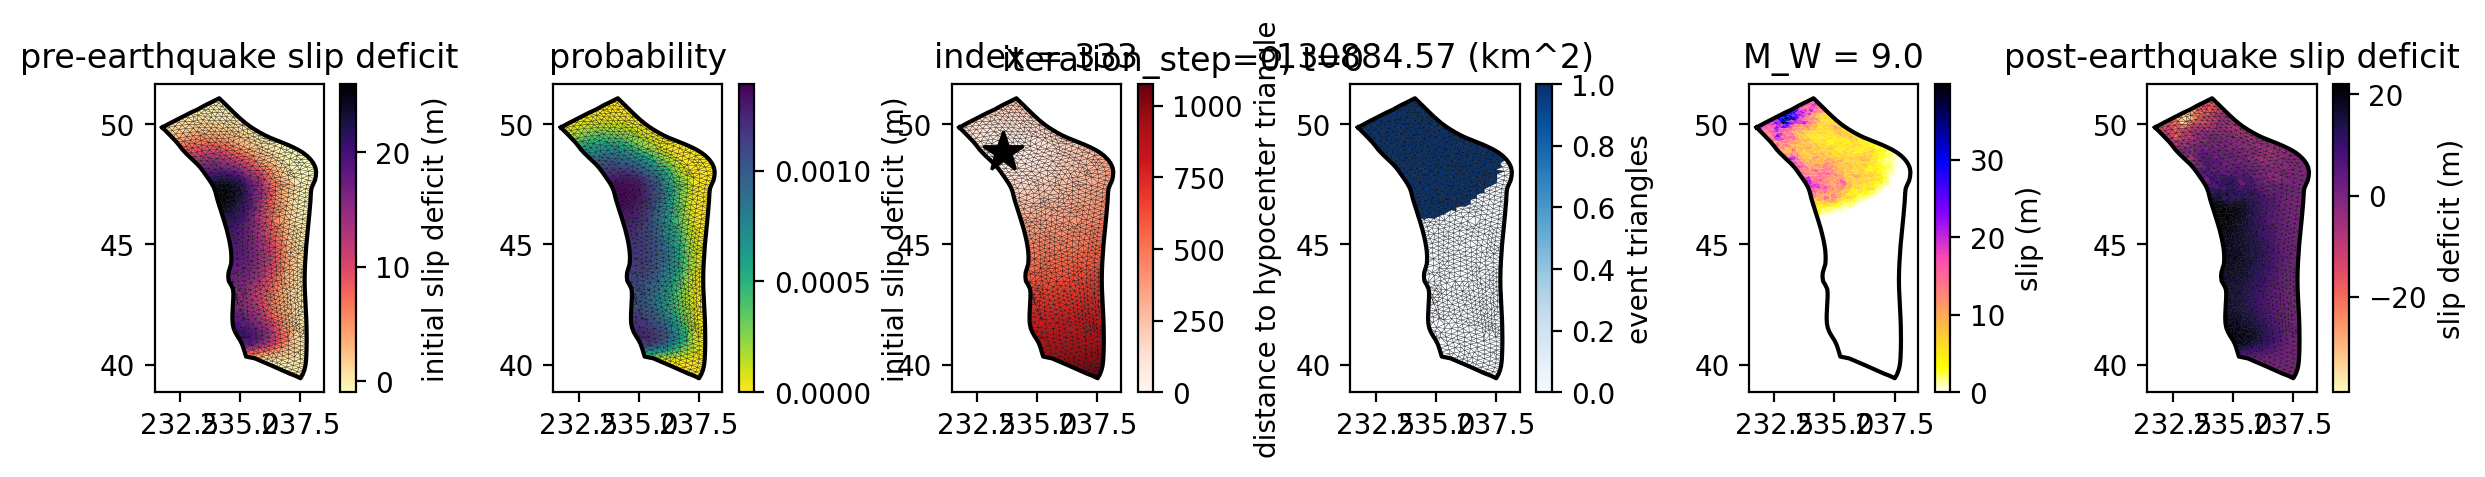

i=1
np.sum(pre_event_slip_deficit > 0)=1339


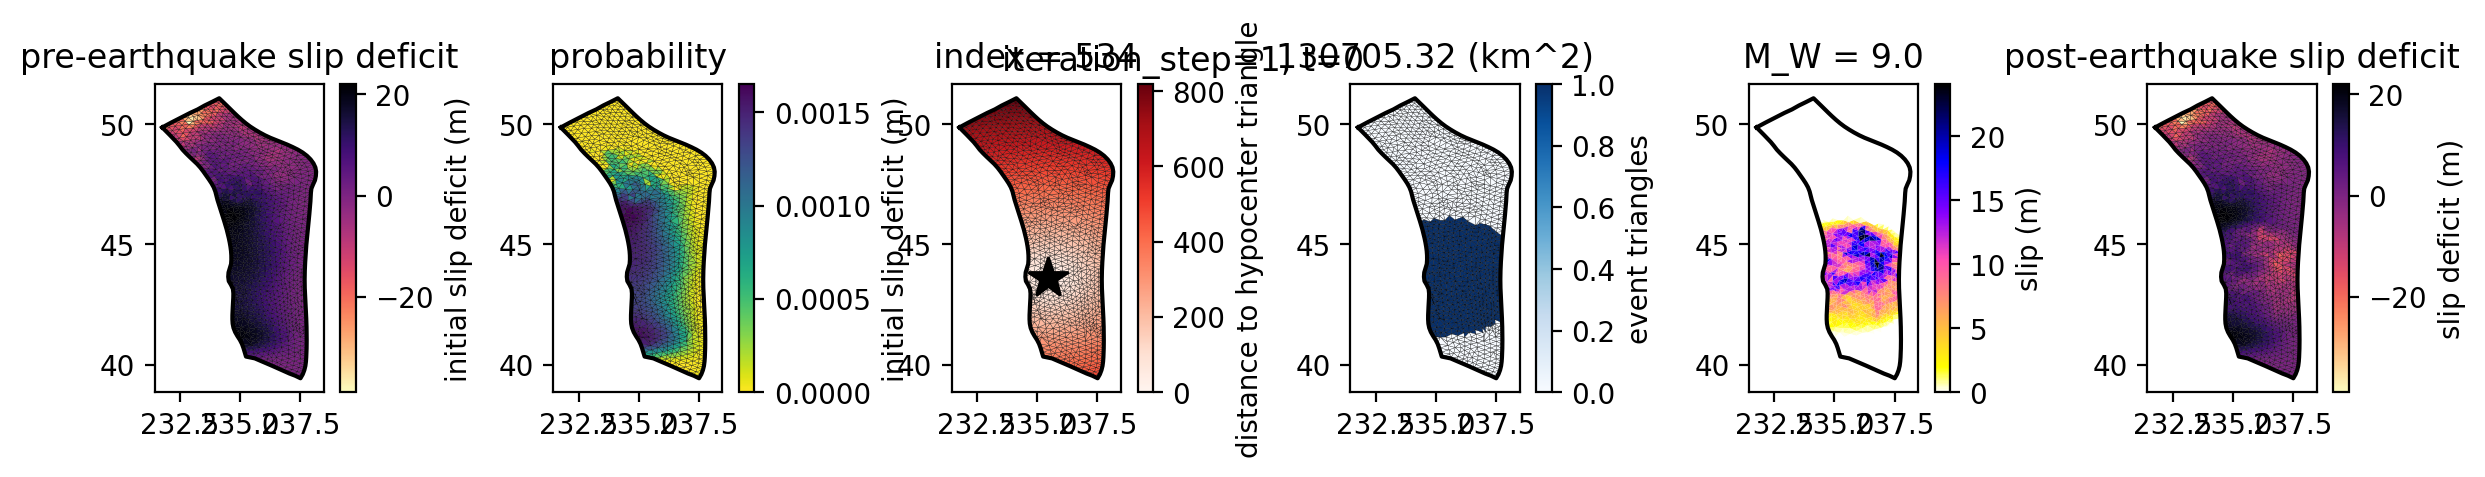

i=2
np.sum(pre_event_slip_deficit > 0)=976


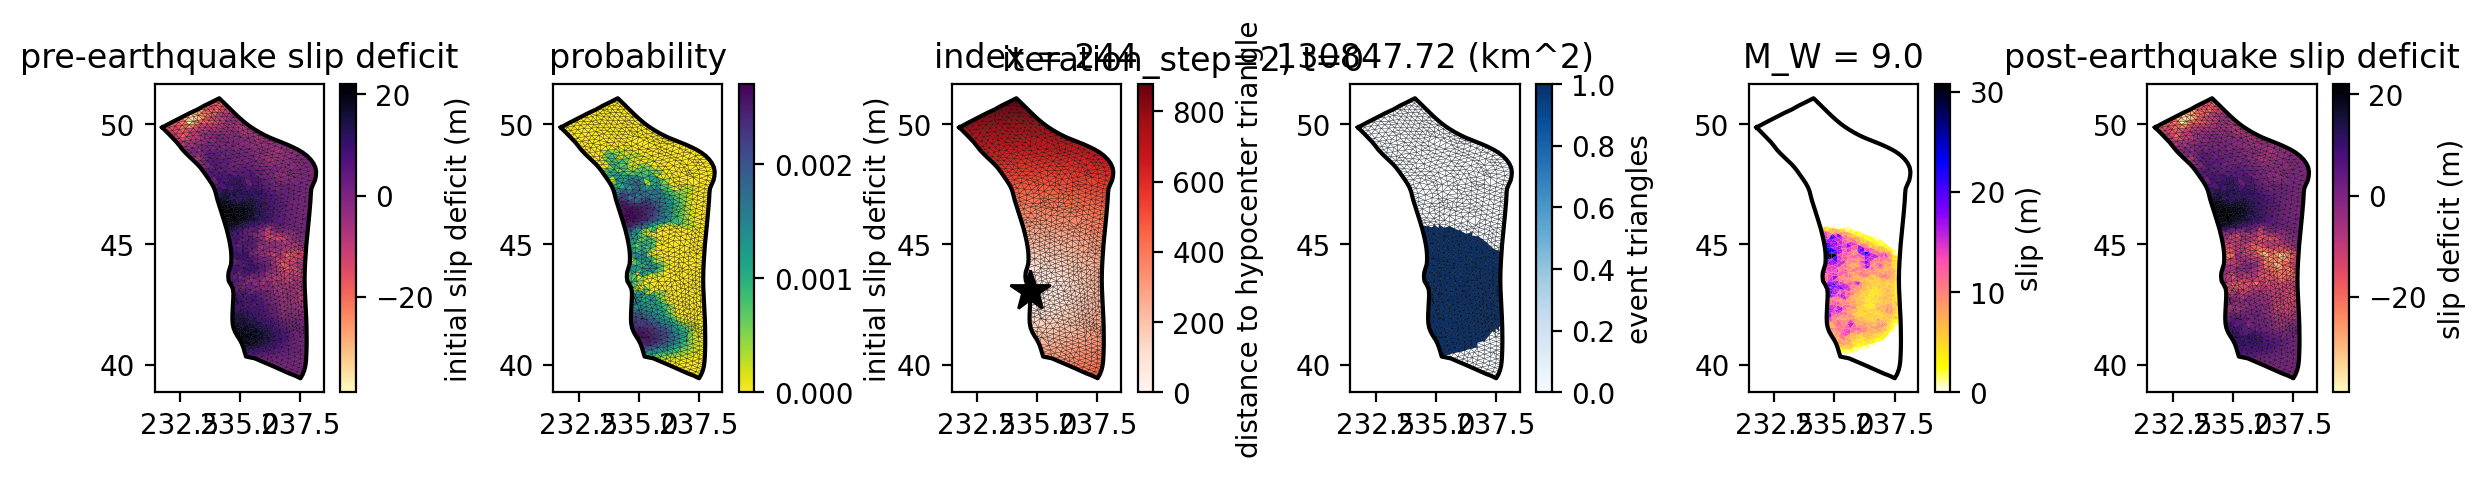

i=3
np.sum(pre_event_slip_deficit > 0)=681


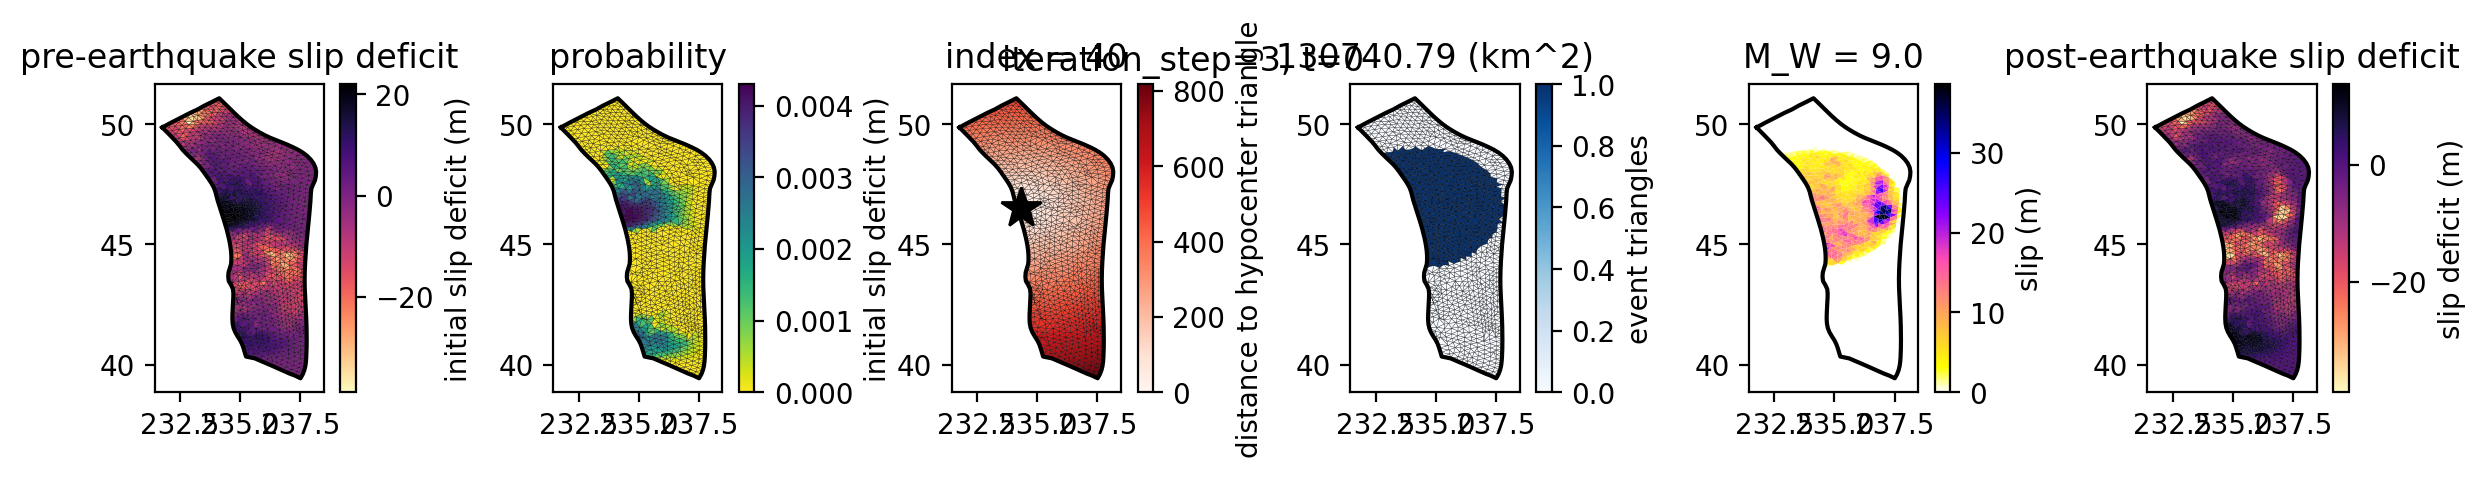

i=4
np.sum(pre_event_slip_deficit > 0)=439


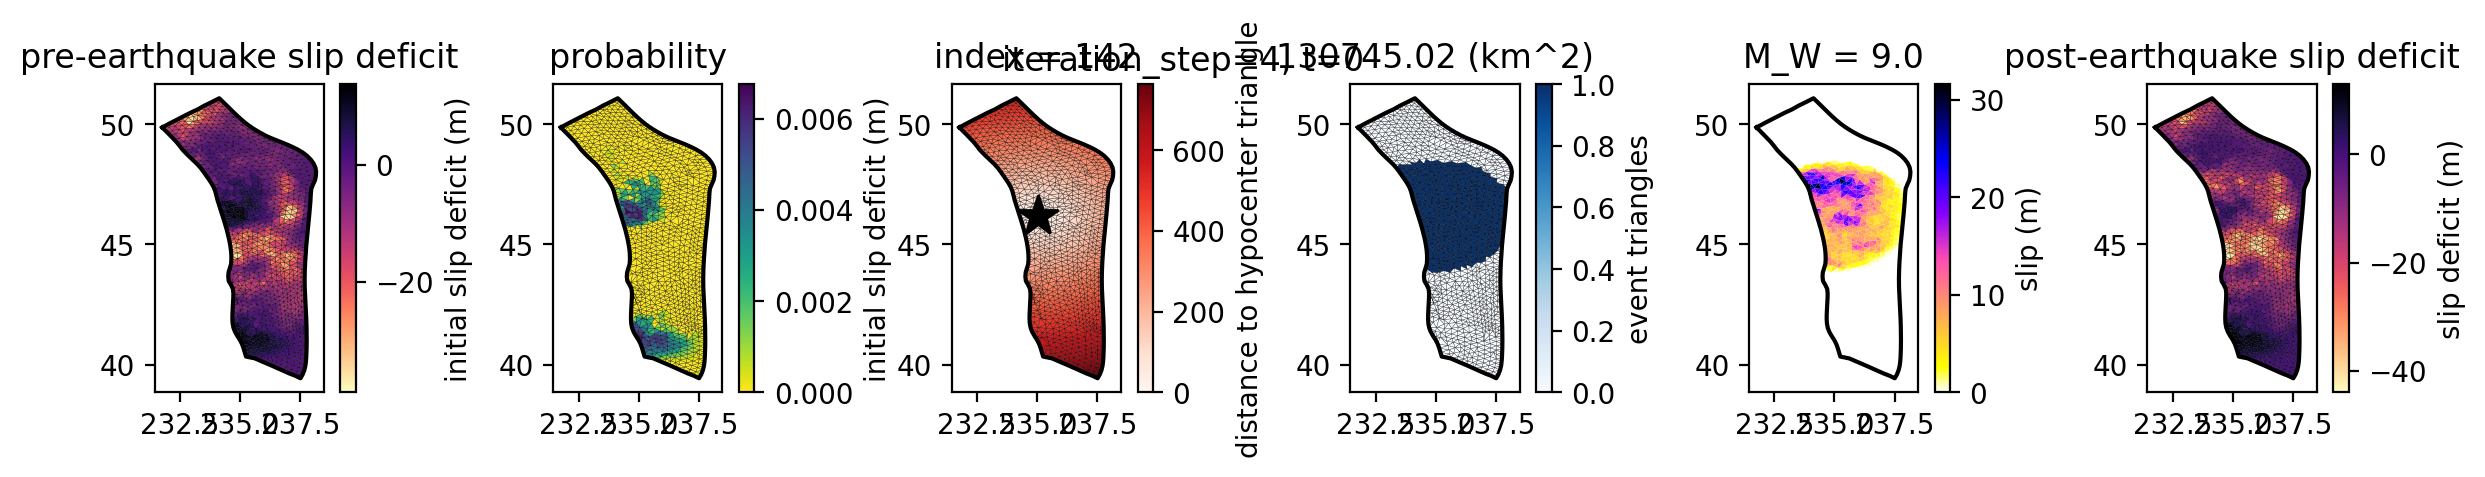

In [6]:
t = 0
pre_event_slip_deficit = initial_dip_slip_deficit
for i in range(5):
    print(f"{i=}")
    print(f"{np.sum(pre_event_slip_deficit > 0)=}")

    # Only go through the event generation process of there is positive slip deficit somewhere
    if np.sum(pre_event_slip_deficit > 0) > 0:
        location_probability = skies.get_location_probability(pre_event_slip_deficit)
        event = skies.create_event(meshes, location_probability)
        total_coseismic_slip += event.slip_all_elements
        post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements
        # print_event(event, meshes)
        skies.plot_event(
            event,
            meshes,
            pre_event_slip_deficit,
            location_probability,
            post_event_slip_deficit,
            t,
            i,
        )
        pre_event_slip_deficit = np.copy(post_event_slip_deficit)


In [7]:
# TODO: #10 Write up eigenvalue shape idea
# TODO: #11 Revisit probability calcuation with sigmoid.  We're generating occasional Nans
# TODO: #15 Write up theory for time probability
# TODO: #14 Code 1D time series example with: 1) loading, 2) coseismic jumps, 2) Omori like decay after earthquake

In [8]:
# 1D time series experiment
np.random.seed(10)


def get_omori_decay_probability(time_vector, time_of_earthquake, amplitude, decay_time):
    omori_decay_probability = amplitude / (
        1 + (1 / decay_time) * (time_vector - time_of_earthquake)
    )

    omori_decay_probability[time_vector < time_of_earthquake] = 0.0
    return omori_decay_probability


MM2M = 1e-3  # millimeters to meters
SECONDS_IN_A_YEAR = 60 * 60 * 24 * 365
DAYS_IN_A_YEAR = 365
n_years = 5000
time_vector = np.linspace(0, n_years, n_years * 1)
minimum_probability = 1e-6
time_probability = np.zeros_like(time_vector)
time_probability_offset = np.zeros_like(time_vector)
time_probability = minimum_probability * np.ones_like(time_vector)

loading_rate = 30.0  # (mm/yr)
earthquake_index_list = []
earthquake_magnitude_list = []
earthquake_probability_list = []
event_trigger_list = []

MINIMUM_EVENT_MOMENT_MAGNITUDE = 6.5
MAXIMUM_EVENT_MOMENT_MAGNITUDE = 9.0

amplitude = 0.01

# TODO: #18 Let gutenberg richter accept min and max magnitudes
# TODO: Figure out why Omori decay isn't showing up
# TODO: Why are all events so large?
# TODO: #20 Merge pre_event_slip_deficit, post_event_slip_deficit and total_slip_deficit

pre_event_slip_deficit = np.copy(initial_dip_slip_deficit)
total_slip_deficit = np.copy(initial_dip_slip_deficit)
total_slip_deficit_scalar = np.zeros_like(time_vector)
time_step = 1e-3
interseismic_loading_rate = initial_dip_slip_deficit

# Main time loop
for i in range(0, len(time_vector) - 1):

    # Determine whether or not there is an event at this time step
    event_trigger = np.random.choice(
        2, 1, p=[1 - time_probability[i], time_probability[i]]
    )
    event_trigger_list.append(event_trigger)

    # Do we have an earthquake at this time step?
    if bool(event_trigger) and (np.sum(total_slip_deficit) > 0):
        print(f"{i=}")
        skies.print_event(event, meshes)

        # Generate a synthetic earthquake
        location_probability = skies.get_location_probability(pre_event_slip_deficit)
        event = skies.create_event(meshes, location_probability)
        # post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements

        # skies.plot_event(
        #     event,
        #     meshes,
        #     pre_event_slip_deficit,
        #     location_probability,
        #     post_event_slip_deficit,
        #     t,
        #     i,
        # )

        earthquake_magnitude_list.append(event.moment_magnitude)
        earthquake_index_list.append(i)
        earthquake_probability_list.append(
            get_omori_decay_probability(
                time_vector, time_vector[i], amplitude, decay_time=100.0
            )
        )
        magnitude_dependent_amplitude = (
            amplitude + amplitude * event.moment_magnitude / 500
        )

        # Update probability of occurence at the next time step
        time_probability_offset[i + 1] = (
            time_probability_offset[i] + magnitude_dependent_amplitude
        )

        # Update the total slip deficit mesh
        total_slip_deficit = (
            total_slip_deficit
            + time_step * interseismic_loading_rate
            - event.slip_all_elements
        )

    else:
        # Sum contribution from all past earthquakes
        # TODO: The scaling factor here is magic
        for j in range(len(earthquake_index_list)):
            time_probability_offset[i + 1] += 10.5 * (
                earthquake_probability_list[j][i + 1]
                - earthquake_probability_list[j][i]
            )

        # Update total_slip_deficiyt for the case when there are no earthquakes
        total_slip_deficit = total_slip_deficit + time_step * interseismic_loading_rate

    # Update the total slip deficit scalar
    total_slip_deficit_scalar[i + 1] = np.sum(total_slip_deficit)

    # Pre-event slip deficit for next time step
    pre_event_slip_deficit = np.copy(total_slip_deficit)

    # Time probability
    # TODO: Should I sigmoid this?
    time_probability[i + 1] = 1e-6 * total_slip_deficit_scalar[i + 1] + time_probability_offset[i + 1]



    # Catch probabilities less than zero
    if time_probability[i + 1] < minimum_probability:
        time_probability[i + 1] = minimum_probability

    # Catch probabilities greater than one
    if time_probability[i + 1] >= 1.0:
        break

print(np.where(np.array(event_trigger_list) == 1)[0][0:10])


i=56
Event data:
Hypocenter longitude = 235.0254 (deg)
Hypocenter latitude = 46.1775 (deg)
Hypocenter depth = -8.3865 (km)
Hypocenter triangle index = 142
Mean slip = 8.93 (m)
Minimum slip = 0.00 (m)
Maximum slip = 31.58 (m)
Moment magnitude = 9.0
Moment = 3.55e+22 (N m)
Number of eigenvalues = 700
Rupture area = 130745.02 (km^2)
Scaling law rupture area = 130891.07 (km^2)
i=63
Event data:
Hypocenter longitude = 235.4024 (deg)
Hypocenter latitude = 42.1555 (deg)
Hypocenter depth = -11.2976 (km)
Hypocenter triangle index = 456
Mean slip = 9.06 (m)
Minimum slip = 0.00 (m)
Maximum slip = 27.43 (m)
Moment magnitude = 9.0
Moment = 3.55e+22 (N m)
Number of eigenvalues = 743
Rupture area = 130885.79 (km^2)
Scaling law rupture area = 130891.07 (km^2)
i=405
Event data:
Hypocenter longitude = 235.3888 (deg)
Hypocenter latitude = 45.4544 (deg)
Hypocenter depth = -14.2768 (km)
Hypocenter triangle index = 549
Mean slip = 9.05 (m)
Minimum slip = 0.00 (m)
Maximum slip = 35.47 (m)
Moment magnitude = 9

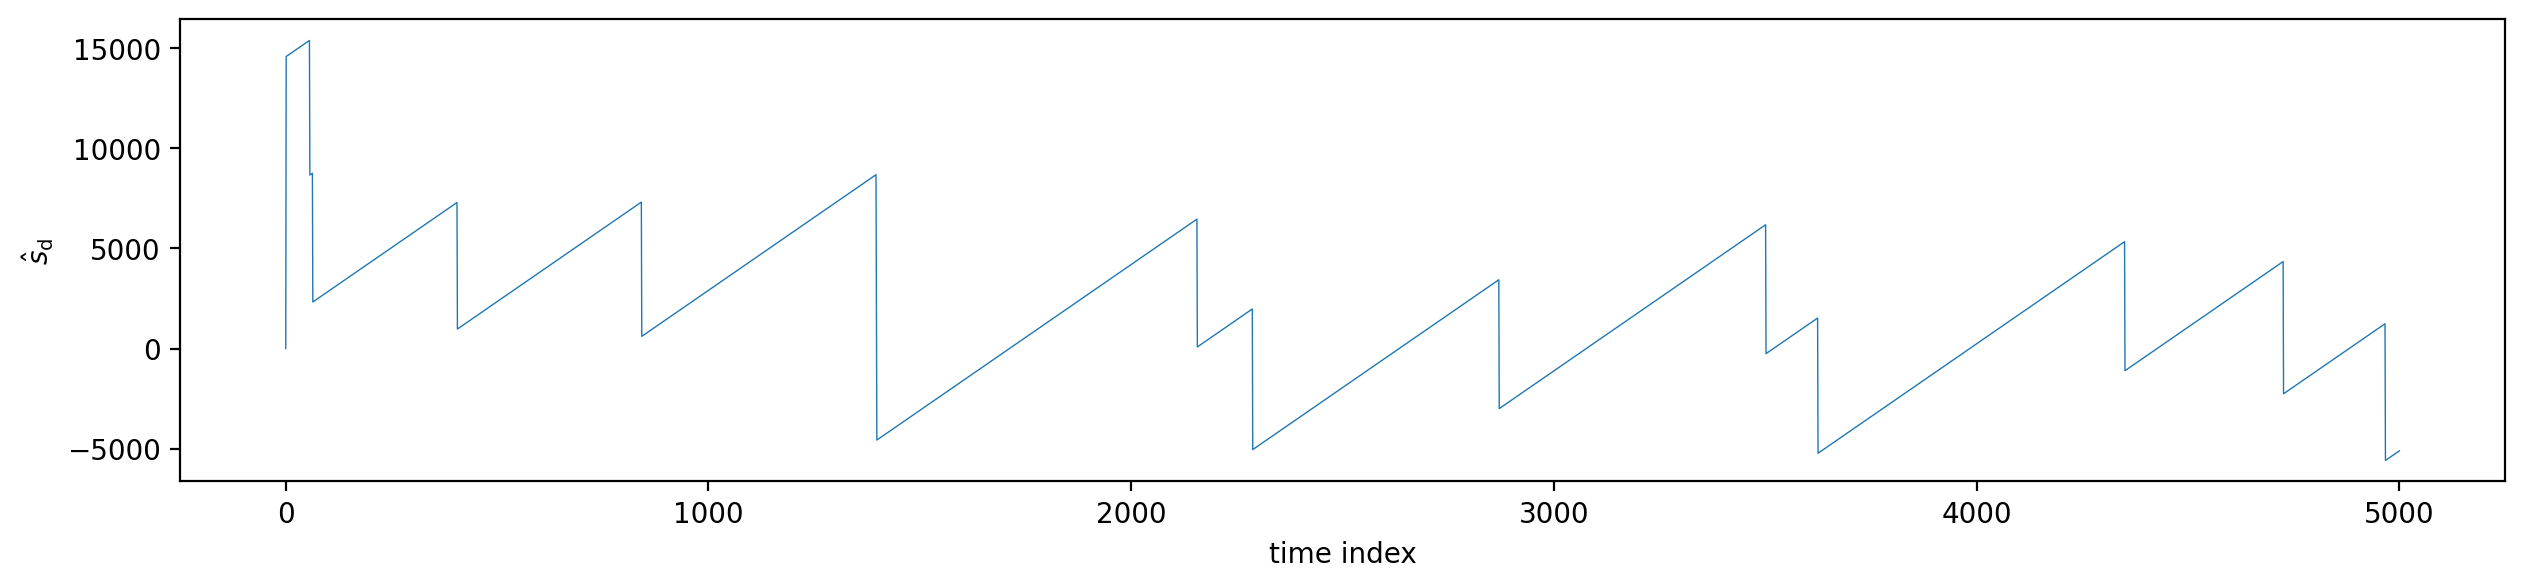

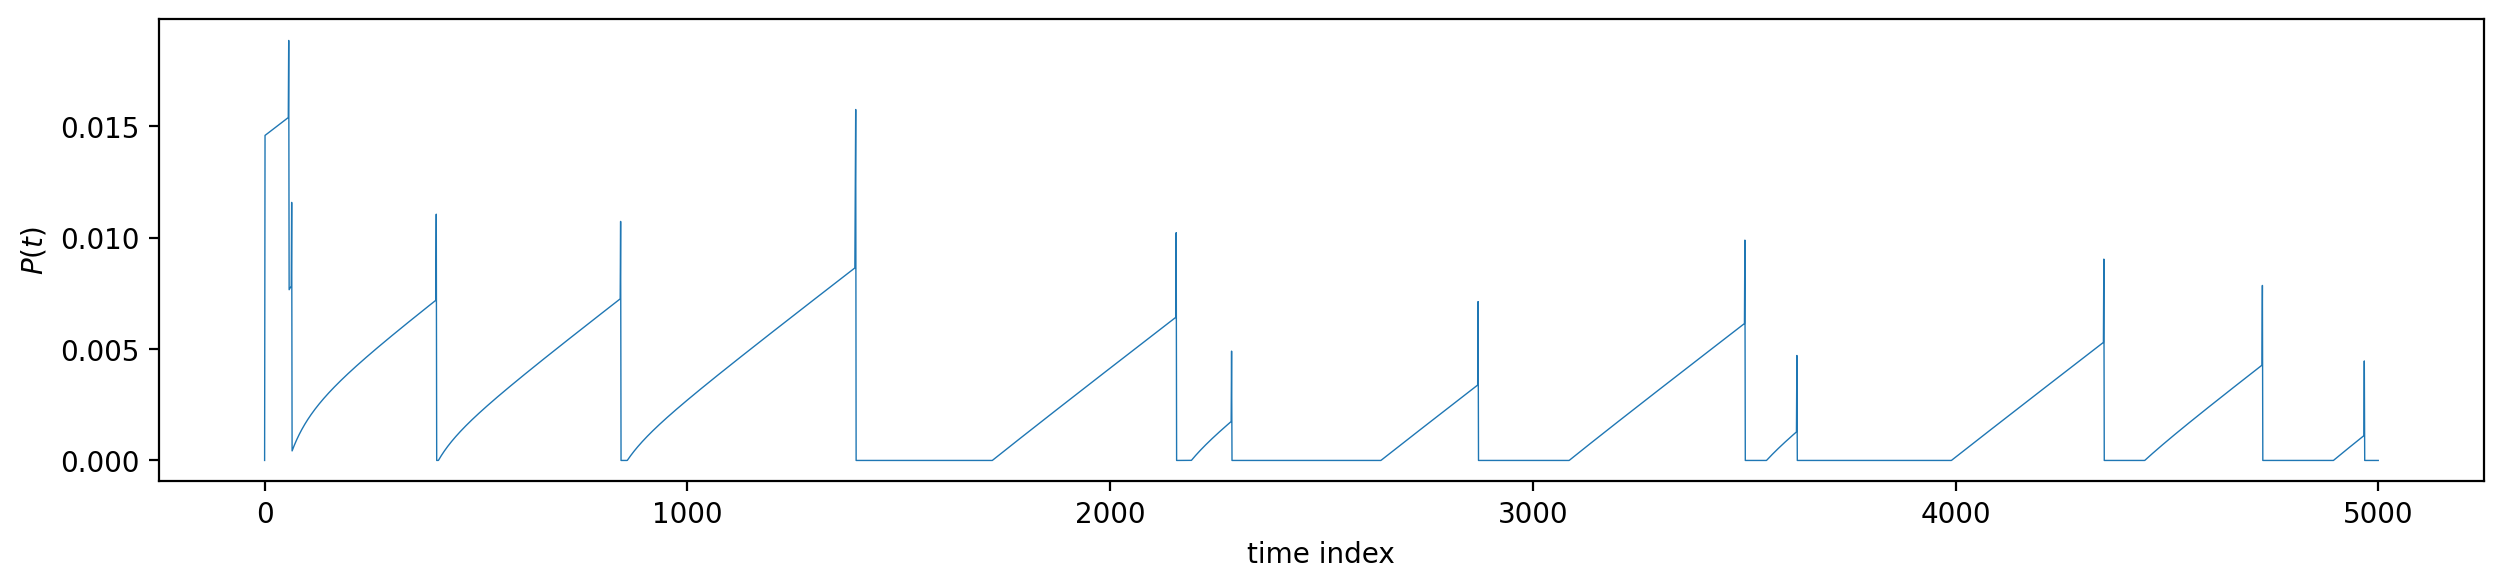

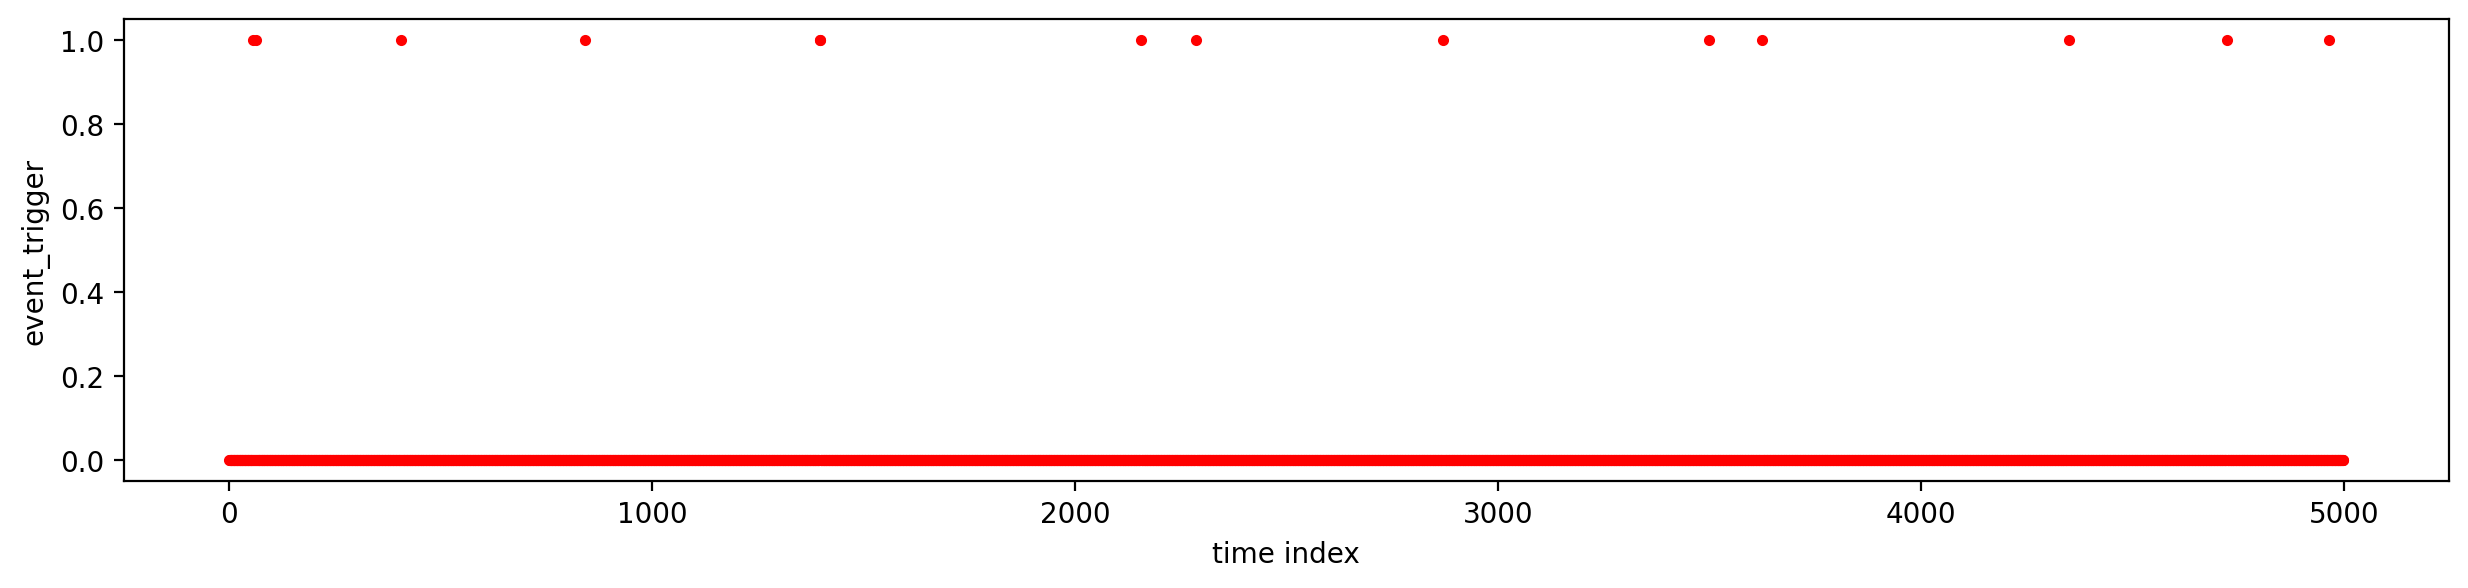

In [9]:
start_idx = 0
end_idx = 30000
figsize = (15, 3)

plt.figure(figsize=figsize)
plt.plot(time_vector[start_idx:end_idx], total_slip_deficit_scalar[start_idx:end_idx], linewidth=0.5)
plt.xlabel("time index")
plt.ylabel("$\hat{s}_\mathrm{d}$")

plt.figure(figsize=figsize)
plt.plot(time_vector[start_idx:end_idx], time_probability[start_idx:end_idx], linewidth=0.5)
plt.xlabel("time index")
plt.ylabel("$P(t)$")

plt.figure(figsize=figsize)
plt.plot(event_trigger_list[start_idx:end_idx], "r.")
plt.xlabel("time index")
plt.ylabel("event_trigger")

plt.show()




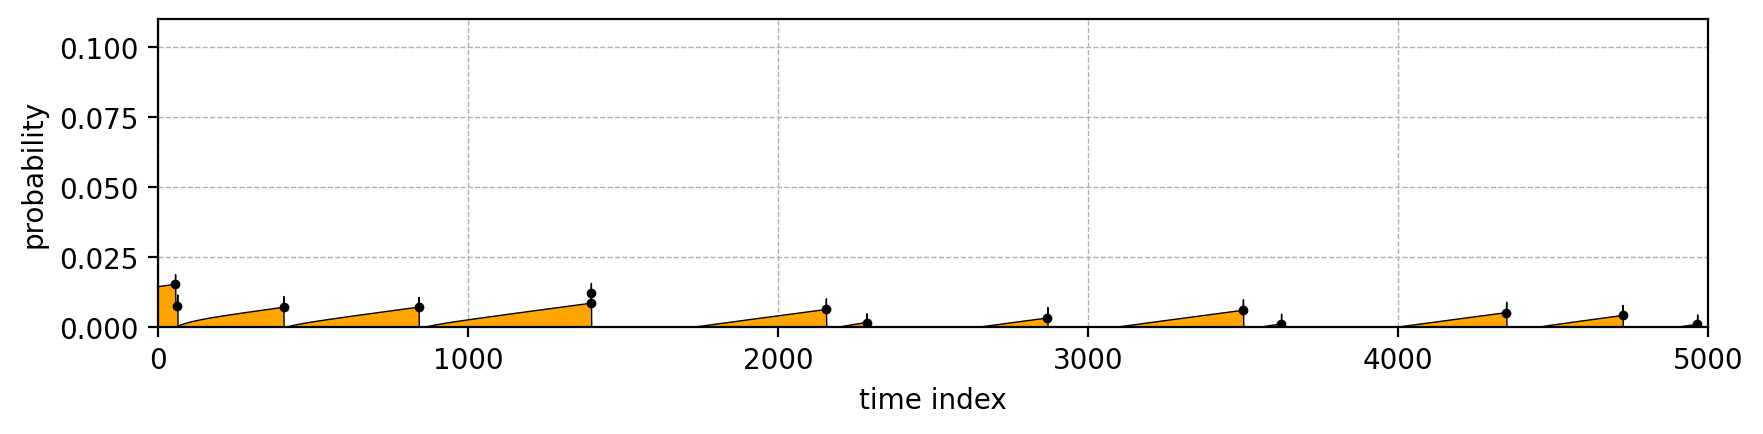

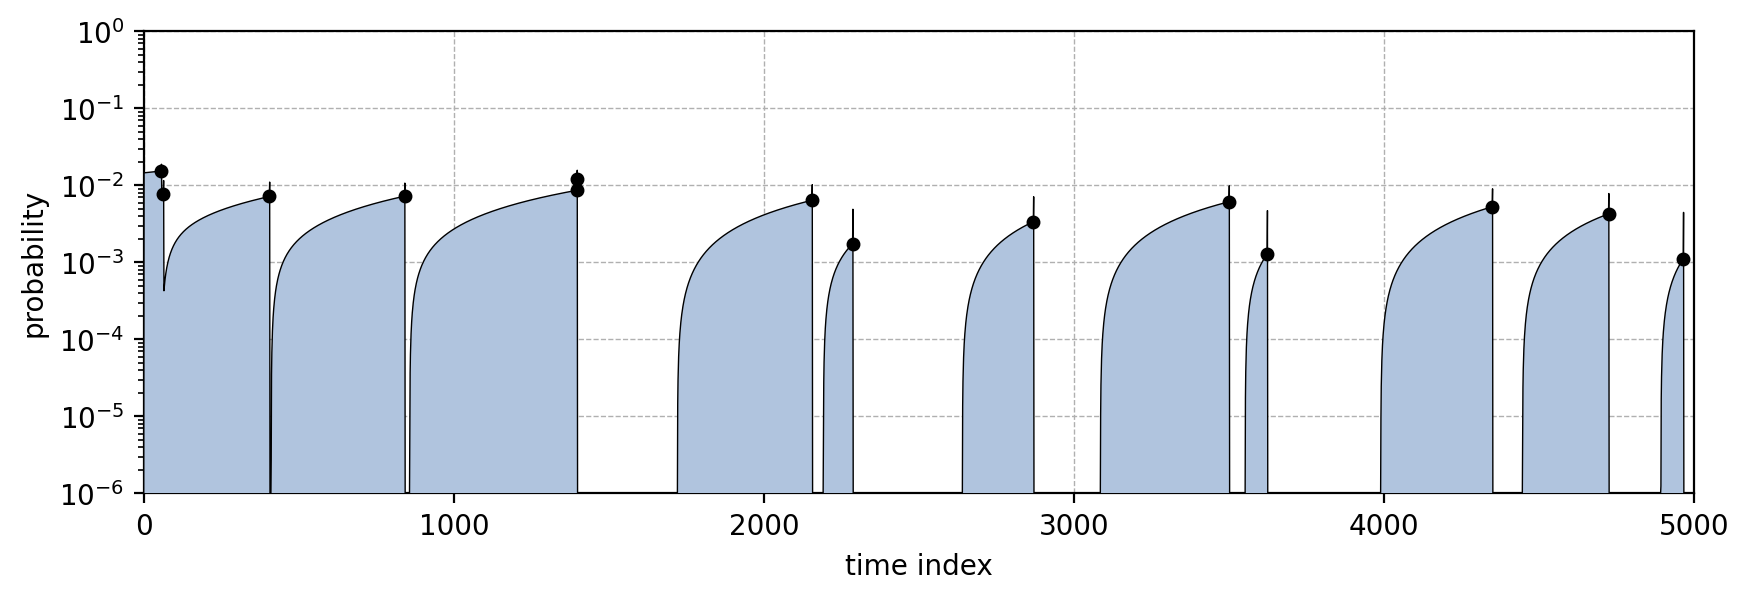

/Users/meade/mambaforge/envs/skies/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


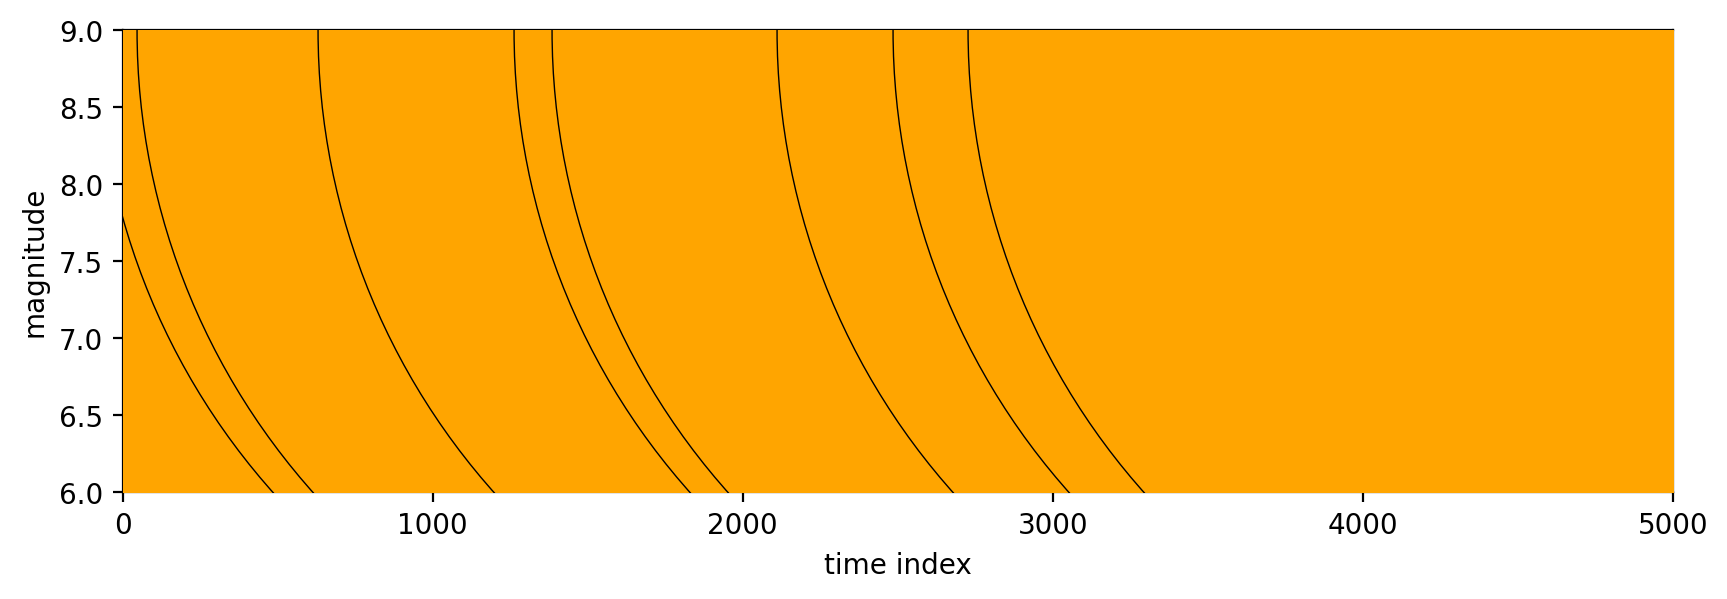

In [10]:
# Non-log plot
plt.figure(figsize=(10, 2))
plt.plot(time_vector, time_probability, "-k", linewidth=0.5, zorder=15)
for i in range(len(earthquake_index_list)):
    plt.plot(
        time_vector[earthquake_index_list[i]],
        time_probability[earthquake_index_list[i]],
        ".k",
        markersize=5,
        linewidth=0.0,
        zorder=20,
    )
plt.fill(
    np.append(time_vector, 0),
    np.append(time_probability, minimum_probability),
    color="orange",
    alpha=1.0,
    edgecolor=None,
)
plt.xlabel("time index")
plt.ylabel("probability")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([0, 0.11])
plt.grid(True, linewidth=0.5, linestyle="--")
# plt.savefig("example_probability_time_series.pdf")
# plt.savefig("example_probability_time_series.png", dpi=500)
plt.show()

# Semilogy plot
plt.figure(figsize=(10, 3))
plt.semilogy(time_vector, time_probability, "-k", linewidth=0.5, zorder=15)
# for i in range(len(earthquake_index_list)):
#     plt.plot(
#         time_vector[earthquake_index_list[i]],
#         time_probability[earthquake_index_list[i]],
#         ".k",
#         markersize=10 ** (earthquake_magnitude_list[i] - 6),
#         alpha=0.5,
#         linewidth=0.0,
#         zorder=20,
#         color="orange",
#         markeredgecolor="k",
#     )

for i in range(len(earthquake_index_list)):
    plt.plot(
        time_vector[earthquake_index_list[i]],
        time_probability[earthquake_index_list[i]],
        ".k",
        markersize=8,
        alpha=1.0,
        linewidth=0.0,
        zorder=20,
        markeredgecolor="k",
    )

plt.fill(
    np.append(time_vector, 0),
    np.append(time_probability, minimum_probability),
    color="lightsteelblue",
    alpha=1.0,
    edgecolor=None,
    zorder=10,
)
plt.xlabel("time index")
plt.ylabel("probability")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([minimum_probability, 1])
plt.grid(True, linewidth=0.5, linestyle="--")
# plt.savefig("example_probability_time_series_semilogy.pdf")
# plt.savefig("example_probability_time_series_semilogy.png", dpi=500)
plt.show()

# Earthquake magnitude plot
plt.figure(figsize=(10, 3))

for i in range(len(earthquake_index_list)):
    plt.plot(
        [time_vector[earthquake_index_list[i]], time_vector[earthquake_index_list[i]]],
        [6.0, earthquake_magnitude_list[i]],
        "-",
        # markersize=10**(earthquake_magnitude_list[i] - 6),
        linewidth=0.5,
        zorder=10,
        color="k",
    )


for i in range(len(earthquake_index_list)):
    plt.plot(
        time_vector[earthquake_index_list[i]],
        earthquake_magnitude_list[i],
        ".",
        markersize=10**(earthquake_magnitude_list[i] - 6),
        # markersize=10,
        alpha=1.0,
        linewidth=0.0,
        zorder=20,
        color="orange",
        markeredgecolor="k",
        markeredgewidth=0.5,
    )
plt.xlabel("time index")
plt.ylabel("magnitude")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([6, 9])
plt.grid(True, linewidth=0.5, linestyle="--")

# plt.savefig("example_magnitude_time_series_semilogy.pdf")
# plt.savefig("example_magnitude_time_series_semilogy.png", dpi=500)
plt.show()


In [11]:
event.moment_magnitude

array([9.])